In [2]:
import h5py, numpy, astropy.time, pylab
from pycbc.events.veto import start_end_to_segments, indices_within_times

f = h5py.File('./summO1O2.hdf', 'r')

bins = numpy.arange(2.0, 30.0, .1)
ifos = ['H1', 'L1', 'V1']
types = [ 'H1L1V1', 'H1L1', 'H1V1', 'L1V1']


# get the population prior
from scipy.interpolate import interp1d
from pycbc.conversions import mchirp_from_mass1_mass2

pop = h5py.File('./simplepopprior.hdf', 'r')
popmc = pop['mchirp'][:]
popprior = pop['prior'][:]
popp = interp1d(popmc, popprior, bounds_error=False)

def reweight_pop(stat, template):
    b = h5py.File('./bbh2.hdf', 'r')
    m1 = b['mass1'][:][template]
    m2 = b['mass2'][:][template]
    mc = mchirp_from_mass1_mass2(m1, m2)
    
    popt = numpy.log(popp(mc))
    #popt = 0
    return(stat + popt)

def reweight_pop2(stat, mc):
    popt = numpy.log(popp(mc))
    #popt = 0
    return(stat + popt)

In [21]:
# prepoulate some segment info
tstart = {}
tend = {}
for t in types:
    tstart[t] = []
    tend[t] = []

segs = {}
for chunk in f.keys():
    chunk = str(chunk)
    
    csegs = {}
    for t in types:
        if t in f[chunk]['background']:
            s = f[chunk]['background'][t]['start'][:]
            e = f[chunk]['background'][t]['end'][:]
            csegs[t] = s, e
            
            tstart[t].append(s)
            tend[t].append(e)
        
    segs[chunk] = csegs
    
for t in types:
    tstart[t] = numpy.concatenate(tstart[t])
    tend[t] = numpy.concatenate(tend[t])
    
def get_on(time):
    for t in types:
        x = indices_within_times(numpy.array([time]), tstart[t], tend[t])
        if len(x) != 0:
            return t

28.8935674819079 0.3415952847714829
25.08660375548532 0.2965873133932059
2.4395508315976926 0.028841681165052677
4.63229152925787 0.05476544026874466


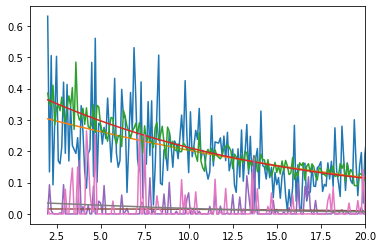

In [4]:
########## Calculate the expected foreground rates ###################
from pycbc.pnutils import chirp_distance

fac = 365.25 / 95.0
count = 22
vref = 2492383.5986011256 # Pulled from O3a data as the reference rate
nexpect = count * fac
nthresh = 20

stats = []
dists = []
times = []
ifars = []
mchirps = []
for chunk in f.keys():
    chunk = str(chunk)

    if 'inj' in f[chunk]:    
        #stat = f[chunk]['inj/stat'][:]
        dist = f[chunk]['inj/dist'][:]
        time = f[chunk]['inj/time'][:]
        ifar = f[chunk]['inj/ifar_exc'][:]
        mc = f[chunk]['inj/mchirp'][:]
        stat = reweight_pop2(f[chunk]['inj/stat'][:], mc)
        stats.append(stat)
        dists.append(dist)
        times.append(time)
        ifars.append(ifar)
        mchirps.append(mc)

stats = numpy.concatenate(stats)
dists = numpy.concatenate(dists)
times = numpy.concatenate(times)
ifars = numpy.concatenate(ifars)
mchirps = numpy.concatenate(mchirps)

cdist = chirp_distance(dists, mchirps)
#pylab.hist(cdist)

which = {}
vave = {}
sig = {}

for t in types:
    x = indices_within_times(times, tstart[t], tend[t])
    
    if 'H1L1V1' in which:
        keep = ~numpy.isin(x, which['H1L1V1'])
        which[t] = x[keep]
    else:
        which[t] = x
    
    w = cdist[which[t]] ** 2.0
    l = ifars[which[t]] > 10.0
    d = cdist[which[t]]
    dave = (w[l] * d[l]).sum() / w[l].sum()
    vave[t] = dave ** 3.0
    
    nw = nexpect / w[stats[which[t]] > nthresh].sum()
    
    nr = vave[t] / vref
    
    c, _ = numpy.histogram(stats[which[t]], weights=nw * w * nr, bins=bins)
    
    l =  numpy.searchsorted(bins, nthresh)
    v = (w * nr * nw)[stats[which[t]] > nthresh].sum()
    print(v, nr)
    
    pylab.plot(bins[:-1], c)
    
    cv = (bins[:-1] + bins[1:]) / 2.0
    p = numpy.polyfit(cv, c, 3)
    
    ybin = numpy.polyval(p, bins)
    pylab.plot(bins, ybin)
    
    pylab.xlim(1, 20)
    sig[t] = ybin

In [5]:
########## Calculate the expected background rates ###################

import pylab

def get_back(chunk, active):
    chunk = str(chunk)    
    #stat = f[chunk]['background/stat'][:]
    stat = reweight_pop(f[chunk]['background/stat'][:], f[chunk]['background/tid'][:])

    dec = f[chunk]['background/dec'][:]
    
    tid = {}
    for ifo in ifos:
        if ifo in f[chunk]['background']:
            tid[ifo] = f[chunk]['background'][ifo]['trig'][:]

    on = {ifo: tid[ifo] != -1 for ifo in tid}

    keep = None
    for j in range(len(active) // 2):
        ifo = active[j*2:j*2 + 2]
        
        if keep is None:
            keep = on[ifo]
        else:
            keep = keep & on[ifo]
            
    stat = stat[keep]
    dec = dec[keep]
    
    btime = f[chunk]['background'][active].attrs['background_time_exc'] / 365.25 / 86400.
    w = dec / btime
    
    le = bins[:-1]
    re = bins[1:]
    
    c, _ = numpy.histogram(stat, weights=w, bins=bins)
    #pylab.plot(bins[:-1], c)
    #pylab.yscale('log')
    #pylab.xlim(10, 20)
    return c

In [8]:
num = 0
for chunk in f.keys():
    chunk = str(chunk)
    
    for i, stat in enumerate(f[chunk]['stat'][:]):
        # get event time
        stat = reweight_pop(stat, f[chunk]['tid'][i])
        if stat < 2.0:
            continue
        times = {}
        for ifo in ifos:
            if ifo in f[chunk]:
                times[ifo] = f[chunk][ifo]['time'][i]
        used = [k for k in times if times[k] != -1]
        used = ''.join(used)
        atime = numpy.mean([times[k] for k in times if times[k] != - 1])
        

        
        # determine which detectors were actually on at this time
        on = get_on(atime)
        
        # get the background and calculate the expectation for 1 year 
        if len(on) == 6:
            bnum = get_back(chunk, 'H1L1')
            #bnum += get_back(chunk, 'H1V1')
            #bnum += get_back(chunk, 'L1V1')
            bnum += get_back(chunk, 'H1L1V1')
        else:
            bnum = get_back(chunk, on) 
            
        # get the expected foreground counts for this type per year
        fnum = sig[on]   
        #print(fnum.sum(), bnum.sum())
        
        bnum[bnum == 0] = bnum[bnum != 0].min()         # limit in case of zero values
        
        
        #calculate pastro
        if (bins > stat).sum() == 0:
            fn = 100000
            bn = 1
        else:
            l = numpy.searchsorted(bins, stat) - 1
            fn = fnum[l]
            bn = bnum[l]
        
        pastro = fn / (fn + bn)
        min_pastro = fnum[0] / (fnum[0] + bnum[0])
    
        ta = astropy.time.Time(atime, format='gps').datetime
        if pastro > 0.2:
            print('%2.2f %s %2.2f %s %2.2f' % ( atime, ta, stat, on, pastro))
            num += 1
    print(i)
print(num)

1177134832.19 2017-04-25 05:54:11.190918 7.29 H1L1 0.37
54
1180922494.49 2017-06-08 02:01:53.488770 55.50 H1L1 1.00
6
33
1187529256.52 2017-08-23 13:14:35.516846 38.80 H1L1 1.00
7
1185152688.03 2017-07-27 01:05:07.033203 17.33 H1L1 1.00
22
31
20
1186302519.75 2017-08-09 08:28:58.750000 41.27 H1L1V1 1.00
22
30
13
1175295989.23 2017-04-03 23:06:48.231689 8.01 H1L1 0.72
24
1182296561.37 2017-06-23 23:43:00.370117 5.74 H1L1 0.23
33
27
1172680691.37 2017-03-04 16:38:30.365967 8.22 H1L1 0.74
19
35
30
1135136350.65 2015-12-26 03:39:29.648926 43.58 H1L1 1.00
22
39
40
1126259462.42 2015-09-14 09:51:21.424561 134.72 H1L1 1.00
31
1128678900.45 2015-10-12 09:55:19.445068 18.49 H1L1 1.00
1128626886.60 2015-10-11 19:28:25.604492 6.76 H1L1 0.24
48
19
35
1185389807.32 2017-07-29 18:57:06.323730 13.07 H1L1 1.00
10
1133380542.41 2015-12-05 19:56:01.409424 6.05 H1L1 0.20
25
11
1186741861.53 2017-08-14 10:31:20.531006 73.47 H1L1V1 1.00
1187058327.08 2017-08-18 02:25:46.083740 22.19 H1L1V1 1.00
23
11832348

In [71]:
cstart = numpy.zeros(len(f.keys()))
cend = numpy.zeros(len(f.keys()))
for k in f.keys():
    s = numpy.inf
    e = -numpy.inf
    for t in types:
        try:
            s = min(s, f[k]['background'][t]['start'][:].min())
            e = max(e, f[k]['background'][t]['end'][:].max())
        except:
            pass
    cstart[int(k)] = s
    cend[int(k)] = e


def get_chunk(time):
    x = numpy.where((time > cstart) & (time < cend))[0]
    if len(x) == 1:
        return x[0]
    else:
        return -1


ptarget = 0.9
atime = 1170079035.73
times = numpy.arange(cstart.min()+1, cend.max()-1, 100000)

for atime in times:
    stats = numpy.arange(3, 12, .1)
    chunk = get_chunk(atime)

    # determine which detectors were actually on at this time
    on = get_on(atime)

    if on is None:
        continue
    
    # get the background and calculate the expectation for 1 year 
    if len(on) == 6:
        bnum = get_back(chunk, 'H1L1')
        bnum += get_back(chunk, 'H1L1V1')
    else:
        bnum = get_back(chunk, on) 

    # get the expected foreground counts for this type per year
    fnum = sig[on]   
    #print(fnum.sum(), bnum.sum())

    bnum[bnum == 0] = bnum[bnum != 0].min()         # limit in case of zero values


    #calculate pastro
    for stat in stats:
        if (bins > stat).sum() == 0:
            fn = 100000
            bn = 1
        else:
            l = numpy.searchsorted(bins, stat) - 1
            fn = fnum[l]
            bn = bnum[l]

        pastro = fn / (fn + bn)
        if pastro > ptarget:
            stat_threshold = stat
            break
        
    print(stat_threshold)

11.100000000000007
11.100000000000007
11.100000000000007
11.100000000000007
10.800000000000008
10.800000000000008
10.900000000000007
10.900000000000007
10.900000000000007
10.900000000000007
10.900000000000007
10.900000000000007
11.200000000000006
11.200000000000006
11.200000000000006
11.200000000000006
10.800000000000008
10.800000000000008
10.800000000000008
10.800000000000008
10.800000000000008
10.800000000000008
10.800000000000008
10.800000000000008
10.800000000000008
10.700000000000006
10.700000000000006
10.700000000000006
10.300000000000006
10.300000000000006
10.300000000000006
10.300000000000006
10.300000000000006
10.300000000000006
10.500000000000007
10.500000000000007
10.500000000000007
10.100000000000007
10.100000000000007
10.100000000000007
10.100000000000007
10.100000000000007
10.100000000000007
10.300000000000006
10.300000000000006
10.300000000000006
10.300000000000006
9.800000000000006
9.800000000000006
9.800000000000006
9.800000000000006
9.500000000000005
9.500000000000005